In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append('../../')
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from DataPreparation.Ingestion.Ingestion import read_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from DataPreparation.Preprocessing.Preprocessing import preprocess_data

#### Ingestion

In [2]:
df = read_data(
    path='../../../DataFiles/house-prices-advanced-regression-techniques/')

In [3]:
x_train_p, y_train, x_val_p, y_val = preprocess_data(df)

# Print Nan values
print(x_train_p.isnull().sum())
print(x_train_p.shape)

columns having only 2 unique values: 3
['Street', 'Utilities', 'CentralAir']
columns having only <=10 unique values: 33
['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
columns having only <=10 unique values: 3
['Neighborhood', 'Exterior1st', 'Exterior2nd']
MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleType_New             0
SaleType_WD              0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 138, dtype: int64
(1095, 138)


#### Initiating the Model

In [4]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=rf_random_params,
                               n_iter=100,
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(x_train_p, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/ziad/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/ziad/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/ziad/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for R

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([22,  5, 45, 25, 28, 16, 19, 47,  9, 47]),
                                        'max_features': [3, 5, 7, 'auto',
                                                         'sqrt'],
                                        'min_samples_split': array([37, 24,  3, 24, 47,  4, 14, 14, 49, 25, 45, 23, 42, 23, 24, 26,  2,
       45, 34,  7]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [5]:
def plot_importance(model, features, num=10, save=False):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

{'n_estimators': 922, 'min_samples_split': 7, 'max_features': 'sqrt', 'max_depth': 22}


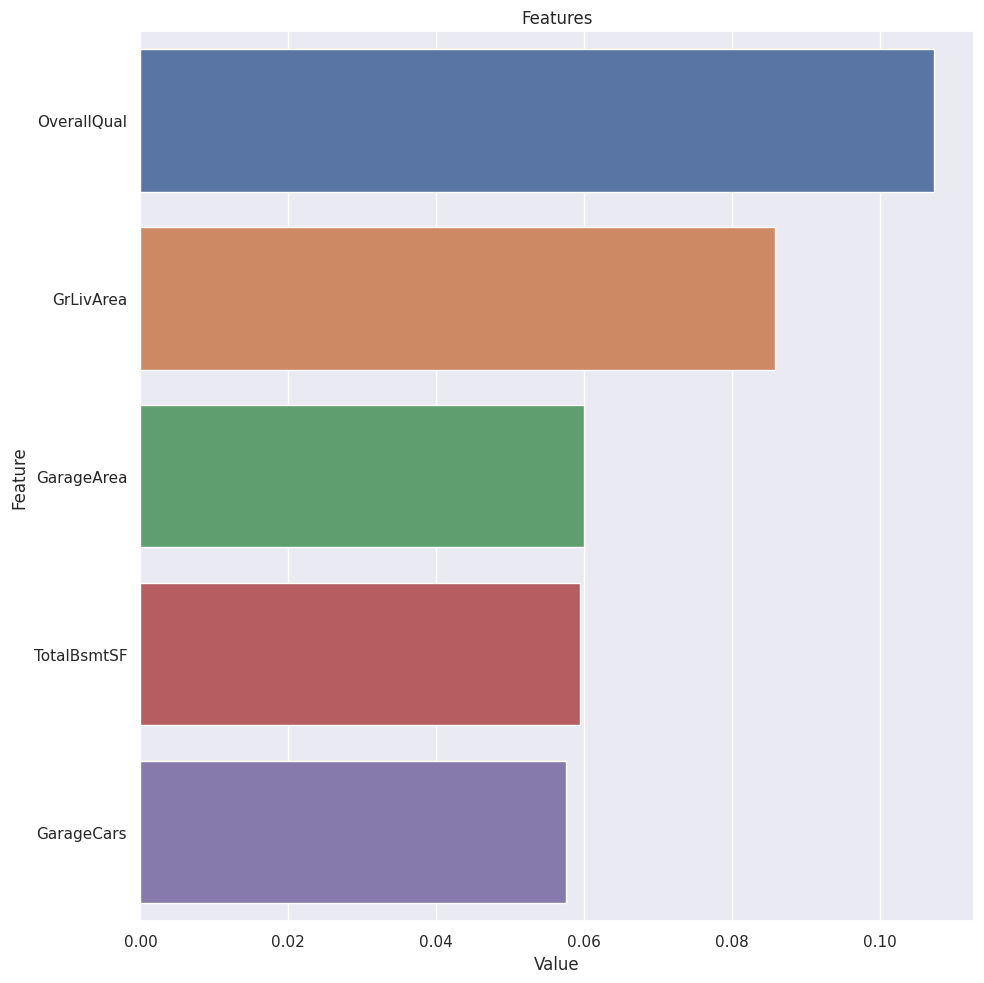

In [6]:
print(rf_random.best_params_)

# Should we train on the whole dataset?
rf_random_final = rf.set_params(
    **rf_random.best_params_, random_state=17).fit(x_train_p, y_train)

plot_importance(rf_random_final, x_train_p, num = 5)

#### Validating the Model

In [7]:
preds_rf = rf_random_final.predict(x_val_p)
mae_rf = mean_absolute_error(y_val, preds_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, preds_rf))

print(mae_rf)
print(rmse_rf)

16618.733744512294
25813.419878898578


#### Saving the Model